# Modelli autoregressivi per la stima del trend e la previsione

- Elisabetta Ripoli <emanuelaripoli@live.it>
- Giuseppe Bellisano <bellisano@gmail.com>

# Sommario

- [Dataset di riferimento](#Dataset-di-riferimento-completo)
- [Definizione di ARIMA](#Definizione-di-ARIMA)
- [Prime Considerazioni](#Prime-Considerazioni)


# Dataset di riferimento completo

Per lo scopo e' stato utilizzato il dataset precedentemente elaborato che contiene, su base giornaliera, la percentuale data dalla somma dei 5 migliori/peggiori titoli azionari del *S&P500* nel periodo 2004-2018

In [0]:
#import libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
#@title Load dataframe

path = 'inputdata_arima.csv' #@param {type:"string"}
column_names = ['data','values']
df = pd.read_csv(path, header = None,  names = column_names)
df = df.set_index('data')

In [0]:
#@title Reduce the dateframe by selecting the date 
b = "2005-03-22" #@param {type:"date"}
a = "2008-03-22" #@param {type:"date"}


df = df.truncate(before = b, after = a)

In [0]:
#@title Reduce the dateframe by selecting a range
#df = df.reset_index()
b = 100 #@param {type:"integer"}
a = 500 #@param {type:"integer"}

#print(a)

df = df['values'].truncate(before = b, after = a)

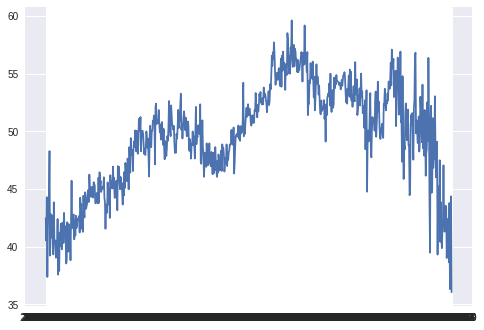

In [6]:
#@title Plot dataset
df = df.reset_index()

x = df['data']
y = df['values']
plt.plot(x,y)

In [12]:
df.dtypes

level_0      int64
index        int64
data        object
values     float64
dtype: object

## Variance and Standard deviance

In [13]:
#@title variance
df['values'].var()

20.740196938595307

In [14]:
#@title standard deviation
df['values'].std()

4.5541406366728845

# Prime considerazioni

## Varianza elevata
Il valore alto relativo alla varianza $s^2$ dimostra che la time series e' *non stazionaria*. Aspetto che e' visibile anche dal grafico che mostra che le fluttuazioni si incrementano nel tempo.

Non e' invece presente un *trend* o un fenomeno di *stagionalita'*.

## Autocovarianza per determinare la Stazionarita' debole
La covarianza tra due elementi della stessa serie e' chiamata **autocovarianza**. 
Per avere una *stazionarita' debole* (weakly stationary) e' necessario che la covarianza tra due elementi della time serie (con lo stesso ritardo *lag*) sia la medesima. Per esempio:

La covarianza tra $x_{t-2}$ e $x_{t-4}$ e' la stessa esistente tra  $x_{t-3}$ e $x_{t-5}$

Nel nostro caso e' necessario ''aggiustare'' la time series utilizzata per trasformarla in una *stazionaria* attraverso il metodo della **prima differenziazione** (first differencing).
***

# Differenziazione per lo studio della stabilita'

## Prima differenziazione
Effettuanto una differenza tra ogni elemento $x_t$ della time series e il suo valore nel periodo precedente $x_{t-1}$, si ottiene la prima differenziazione con cui e' possibile rimuovere eventuali *trend* e *varianza*  che rendono la time serie non stazionaria.

In [0]:
# prima differenziazione

dfp1 = df.set_index('data')
dfp1 = dfp1.diff()

Plot del modello autoregressivo del primo ordine

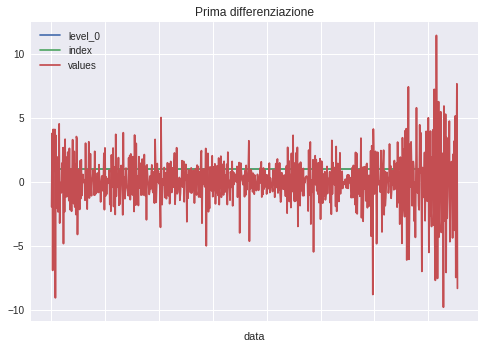

In [16]:
dfp1.plot(kind='line', grid=True, title='Prima differenziazione')

In [20]:
#@title standard deviance
dfp1['values'].std()

2.0944482960248463

Dal grafico sovrastante e' possibile notare che le fluttuazioni della varianza risultano ancora importanti, rendendo la time serie *non stazionaria*. In questi casi e' possibile procedere con la **seconda differenziazione**.

## Seconda differenziazione
Nella second-difference ogni elemento nella nuova time serie e' la differenza tra due elementi consecutivi nella time serie della first-difference.

In [0]:
dfp2 = df.set_index('data')
dfp2 = dfp2.diff(periods=2)

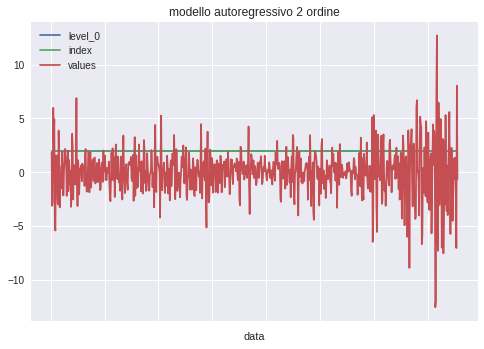

In [22]:
dfp2.plot(kind='line', grid=True, title='modello autoregressivo 2 ordine')

In [24]:
#@title standard deviance
dfp2['values'].std()

2.1904036983071458

una volta resa stazionaria la serie, e' possibile applicare il modello ARIMA ai nostri dati.

# Trasformazione Log
Applicata alla time serie originale, la trasformazione log ha la funzione di appiattire i valori, trasformando la curva *esponenziale* in una *lineare*.
Il vantaggio di questo approccio e' quello di avere una rappresentazione differente della time serie, preservando i minimi e i massimi (locali e globli).

**Quindi viene utilizzata per diminuire la varianza dei dati (articolo ripoli) ma funziona?**

In [0]:
#df.set_index('data', inplace=True)
df['natural log'] = df['values'].apply(lambda x:np.log(x))
df['natural log'].plot(figsize=(16, 12))

# Rolling variance
Applichiamo la *rolling variance statistic* sia alla time serie orginale che a quella *logged*

**e' corretto?**

In [0]:
df['original variance'] = df['values'].rolling(30).var()
df['original variance'].plot()
df.head(5)

## Sample autocorrelation function (ACF)
Per identificare il tipo di processo seguito dalla time serie, inizialmente  disegniamo due funzioni chiave:

- Sample autocorrelation function (ACF)
- Sample partial autocorrelation function (Partial ACF)

ACF e il Partial ACF permettono di esaminare la correlazione tra gli elementi della time serie in funzione dei loro ritardi (lag). 

Calcolando queste due funzioni in relazione alla prima differenziazione del nostro dataset, e' possibile capire se la time serie segue un processo:

- moving average (MA)
- autoregressive (AR)
- una combinazione due due (autoregressive moving average (ARMA))
- integrated (I)

Qui di seguito vengono calcolati gli ACF applicati alle time serie (prima e seconda differenziazione) in funzione dei ritardi.


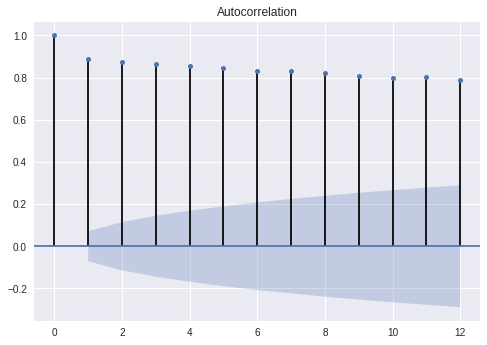

In [33]:
#@title plot ACF of original time serie with optional setting lag
from statsmodels.graphics.tsaplots import plot_acf
lag = 12 #@param {type:"integer"}

plot_acf(df['values'], lags=lag)
plt.show()

Dal grafico si puo' una correlazione positiva con i primi 400 ritardi,che corrispondono ad una *correlazione significativa* di 0.5, 0.6.

I grafici di autocorrelazione sono spesso usati per verificare la casualità in serie temporali. Questo viene fatto calcolando le autocorrelazioni per i valori dei dati a diversi ritardi temporali. Se le serie temporali sono casuali, tali autocorrelazioni dovrebbero essere prossime allo zero per tutte le separazioni temporali. Se le serie temporali sono non casuali, una o più delle autocorrelazioni saranno significativamente diverse da zero. Le linee orizzontali visualizzate nel grafico corrispondono a bande di confidenza del 95% e del 99%. La linea tratteggiata è una banda di confidenza del 99%. Vedere la voce di Wikipedia per ulteriori informazioni sui grafici di autocorrelazione.
__[Wikipedia](https://en.wikipedia.org/wiki/Correlogram)__


## Partial autocorrelation function (PACF)

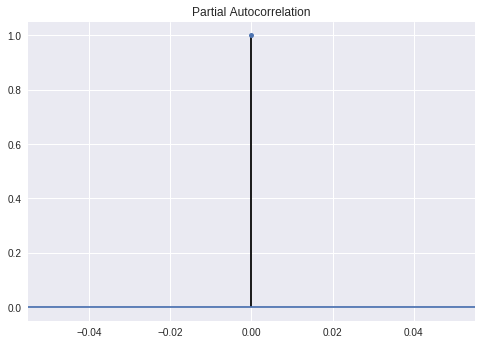

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf

lag = 0 #@param {type:"integer"}

plot_pacf(df['values'], lags=lag)
pyplot.show()

## Primo modello ARIMA
Definiamo un modello ARIMA (400,1,0) cosi definitio:

- autoregressione: 400
- prima differenziazione: 1 (per rendere la time serie stazionaria)
- moving average: 0

In [0]:
# set index on "data"
df = df.set_index('data')

In [48]:
#@title Arima parameters
from statsmodels.tsa.arima_model import ARIMA

# fit model
p = 2 #@param {type:"integer"}
d = 1 #@param {type:"integer"}
q = 0 #@param {type:"integer"}

model = ARIMA(df['values'], order=(p,d,q))
model_fit = model.fit(disp=0)

print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.values   No. Observations:                  754
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -1509.449
Method:                       css-mle   S.D. of innovations              1.791
Date:                Thu, 06 Dec 2018   AIC                           3026.898
Time:                        14:56:27   BIC                           3045.399
Sample:                    03-23-2005   HQIC                          3034.025
                         - 03-20-2008                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0045      0.035     -0.130      0.896      -0.073       0.064
ar.L1.D.values    -0.5791      0.035    -16.552      0.000      -0.648      -0.511
ar.L2.D.values    -0.2942      0.035

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


## Residual Error

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


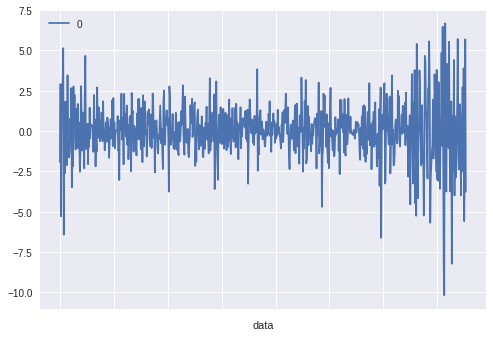

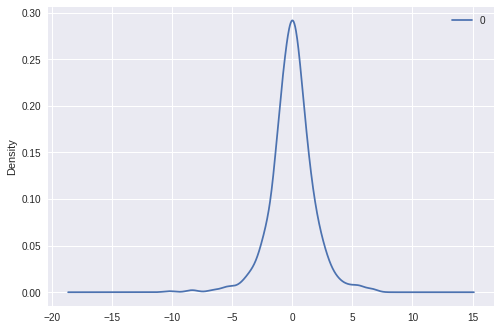

                0
count  754.000000
mean    -0.000431
std      1.792731
min    -10.195310
25%     -0.911593
50%      0.019649
75%      0.911306
max      6.680006


In [49]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

# Arima forecasting model

In [0]:
#@title Arima parameters
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

path = 'inputdata_arima.csv' #@param {value:"string"}
column_names = ['data','values']
series = pd.read_csv(path, header = None,  names = column_names)

series = series.set_index('data')

X = series.values

percTrain = 0.53 #@param {type:"slider", min:0, max:1, step:0.01}
size = int(len(X) * percTrain)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
  
    p = 1 #@param {type:"slider", min:0, max:400, step:1}
    d = 1 #@param {type:"slider", min:0, max:2, step:1}
    q = 0 #@param {type:"slider", min:0, max:400, step:1}

    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

In [65]:
#@title mean squared error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 6.427


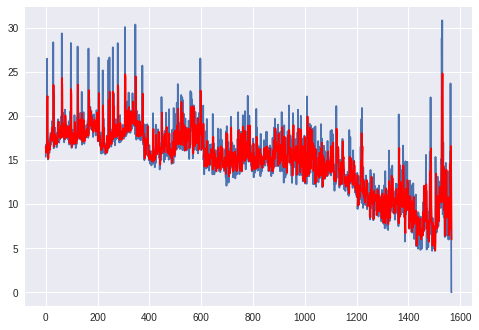

In [67]:
# plot test (blue) and predictions (red)
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

Viene stampatato un sommario del modello fit, dove sono visualizzati i coefficienti, la deviazione standard.

Invece il grafico degli errori residui ci permette di vedere se esistono altre informazioni sul trend non catturate dal modello.

# Previsioni con il modello ARIMA
Inizialmente si suddivide il dataset in due insiemi distinti: un training set per addestrare il modello e uno per fare le predizioni.

Il dataset utilizzato e' comporto da 3336 valori che verranno suddivisi destinandone alla fase di training il 66%. Il restante 34% verra' invece utilizzato per la fase di forecasting, ovvero di previsione.

Per la differenziazione (atta a stabilizzare la time serie) sie' utilizzato il parametro *d = 1* (prima differeniazione)

# Definizione di ARIMA

ARIMA (autoregressive integrated moving average) viene utilizzato per lo sviluppo di un modello predittivo.

La modellazione ARIMA e' valida solo per time series che sono, allo stesso tempo:
- stazionarie
- non stagionali

## Test per la stazionarita'
Esistono due modi per valutare la *non stazionarita'* di una time series:
- osservare se la time serie contiene un *__trend__*
- osservare se la *__varianza__* di una time series cambia nel tempo

Dalla visione del grafico non si visualizza nessun trend che indichi una *non stazionarita'*, si notano pero' delle fluttuazioni nel tempo che indicano una *fluttuazione della varianza*: questo indica che siamo in presenza di **serie temporali non stazionarie**

# Modelli autoregressivi

I modelli autoregressivi permettono di effettuare previsioni sulle series time. Frequentemente i valori osservati in un certo istante temporale sono altamente correlati con i valori della serie che li precedono e che li seguono.

- si parla di **autocorrelazione** del *primo ordine* quando si misura la relazione tra valori consecutivi di una serie storica

- l'autocorrelazione del *secondo ordine* rappresenta il grado di relazione che esiste tra elementi distanti due periodi di tempo

- in generale l'autocorrelazione del *p*-esimo ordine miisura la relazione esistente tra i valori della serie distanti *p* periodi
***


Modello autoregressibvo del primo ordine
$$Y_t = A_0 + A_1 Y_{i-1} + \delta_i$$

Modello autoregressibvo del secondo ordine
$$Y_t = A_0 + A_1 Y_{i-1} + A_2 Y_{i-2} + \delta_i$$

Modello autoregressibvo del *p*-esimo ordine
$$Y_t = A_0 + A_1 Y_{i-1} + A_2 Y_{i-2} + A_p Y_{i-p} + \delta_i$$

dove:

- $Y_i$ valore osservato nel tempo *i*
- $Y_{i-1}$ valore osservato nel tempo *i*-1
- $Y_{i-2}$ valore osservato nel tempo *i*-2
- $Y_{i-p}$ valore osservato nel tempo *p*-2
- $A_0$ costante da stimare attraverso il metodo dei minimi quadrati
- $A_1, A_2, \dots, A_p$ parametri autoregressivi da stimare con modeto dei minimi quadrati
- $\delta_i$ componente erratica non correlata con media nulla e varianza costante

# Modello autoregressivo del *primo ordine*
Inizialmente e' stato scelto un modello autoregressivo del *primo ordine* al fine di semplificare la sua implmementazione e studiare la relazione tra i dati distanti un solo periodo.

# Test di significativita'
Il passo successivo e' quello di scegliere un modello di un particolare ordine *p*. 

Abbiamo individuato come utile ai nostri scopi il modello di ordine **boh**, grazie ad una verifica di ipotesi: ci siamo basati sul **test t** che misura la significativita' del coefficiente $A_p$. Le ipotesi nulla e alternativa sono:

- $H_0: A_p = 0$ (il paramentro di ordine piu' elevato e' pari a $0$
- $H_1: A_p \neq 0$ (il paramentro di ordine e' significativamente diverso da $0$

***
### Test *t* per la significativita' del modello autoregressivo di ordine piu' elevato
$$ t = \frac{a_p - A_p}{S_{\mathrm{a}_p}}$$

dove:
- $a_p$ = stima del parametro $Ap$ di ordine piu' elevato nel modello autoregressivo
- $S_{\mathrm{a}_p}$ deviazione standard di $a_p$

***

### Parametri troppo elevati
Se l'ipotesi nulla ($A_p = 0$) non viene rifiutata, allora il modello utilizzato ha un numero troppo elevato di parametri. In questo caso il termine di ordine piu' elevato viene rifiutato e si effettua il test su un modello di ordine immeediatamente inferiore $p -1$.

<img src="img/regioneAccettazione.png" alt="Regione accettazione/non accettazione" title="Title text" width="50%" height="50%"/>

$$
H_0 = 
  \begin{cases}
    t > t_{n-2p-1} & \quad \text{rifiuto } H_0 \rightarrow A_p \neq 0 \\
    t > -t_{n-2p-1} & \quad \text{rifiuto } H_0 \rightarrow A_p \neq 0 \\
    -t_{n-2p-1} > t > -t_{n-2p-1} & \quad \text{non rifiuto } H_0 \rightarrow A_p = 0 \quad \text{(troppi parametri)} \\
  \end{cases}
$$
***

***

# Dataframe 2009-2010

In [0]:
df = df.set_index()

In [0]:
df2 = df.truncate(before=pd.Timestamp('2009-01-05'),  after=pd.Timestamp('2010-01-10'))

In [0]:
df2.plot()

In [0]:
# variance
df2.var()

In [0]:
#std
df2.std()

In [0]:
# Prima differenziazione
df2p1 = df2.diff(periods=1)

In [0]:
# Prima differenziazione
df2p2 = df2p1.diff(periods=2)

# Grafico della prima e seconda differenziazione

In [0]:
df2p1.plot(kind='line', grid=True, title='modello autoregressivo 1 ordine')

In [0]:
df2p2.plot(kind='line', grid=True, title='modello autoregressivo 2 ordine')

# Funzione Autocorrelazione (ACF)

In [0]:
# grafico di autocorrelazione della time serie originale
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df2)

# Funzione Parziale Autocorrelazione(PACF)

In [0]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df2, lags=20)
pyplot.show()

In [0]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as no

X = df2.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
#pyplot.plot(test)
#pyplot.plot(predictions, color='red')


pyplot.show()